In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preprocessing & Cleanning**

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/AIANDML/trum_tweet_sentiment_analysis.csv')  # Replace with your actual file

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#", '', text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r"\d+", '', text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning
data['cleaned_text'] = data['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


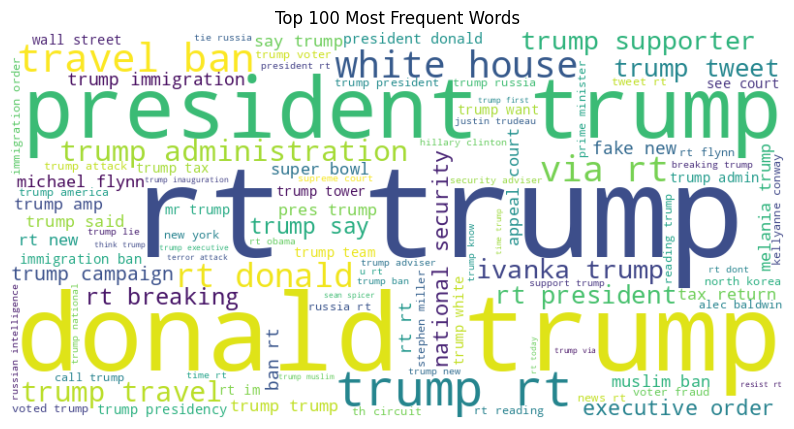

In [3]:
all_words = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_words)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()

In [ ]:
print(data.columns)

Index(['text', 'Sentiment', 'cleaned_text'], dtype='object')


# **Tokenization & Padding**

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Encode sentiment if not binary
data['Sentiment'] = data['Sentiment'].replace({'positive': 1, 'negative': 0})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'], data['Sentiment'], test_size=0.2, random_state=42
)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding using 95th percentile
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# **Model Building**

**RNN Model**

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
rnn_model.add(SimpleRNN(64))
rnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**LSTM**

In [6]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1, activation='sigmoid'))

# **Training & Evaluation**

In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Compile the model
model = lstm_model  # or rnn_model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9206 - loss: 0.1986

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 128s 7ms/step - accuracy: 0.9206 - loss: 0.1986 - val_accuracy: 0.9622 - val_loss: 0.1070
Epoch 2/10
18494/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9674 - loss: 0.0929

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 131s 6ms/step - accuracy: 0.9674 - loss: 0.0929 - val_accuracy: 0.9686 - val_loss: 0.0910
Epoch 3/10
18497/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9760 - loss: 0.0693

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.9760 - loss: 0.0693 - val_accuracy: 0.9704 - val_loss: 0.0870
Epoch 4/10
18495/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9811 - loss: 0.0547

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 136s 6ms/step - accuracy: 0.9811 - loss: 0.0547 - val_accuracy: 0.9719 - val_loss: 0.0856
Epoch 5/10
18496/18502 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9845 - loss: 0.0449

18502/18502 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - accuracy: 0.9845 - loss: 0.0449 - val_accuracy: 0.9720 - val_loss: 0.0897
Epoch 6/10
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - accuracy: 0.9879 - loss: 0.0356 - val_accuracy: 0.9716 - val_loss: 0.0980
Epoch 7/10
18502/18502 ━━━━━━━━━━━━━━━━━━━━ 124s 7ms/step - accuracy: 0.9901 - loss: 0.0294 - val_accuracy: 0.9716 - val_loss: 0.1022


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes))
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

11564/11564 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
Accuracy: 0.9718397405580704
Confusion Matrix:
 [[244160   4403]
 [  6017 115445]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    248563
           1       0.96      0.95      0.96    121462

    accuracy                           0.97    370025
   macro avg       0.97      0.97      0.97    370025
weighted avg       0.97      0.97      0.97    370025



# **GUI**

In [11]:
# Save trained model
model.save('sentiment_model.h5')


In [13]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [15]:
# Install required packages
!pip install gradio tensorflow nltk --quiet

# Imports
import gradio as gr
import tensorflow as tf
import pickle
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')

# Load model and tokenizer
model = tf.keras.models.load_model('sentiment_model.h5')
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return " ".join(text)

# Prediction function
def predict_sentiment(text):
    cleaned = clean_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=100)
    pred = model.predict(padded)[0][0]
    label = "Positive 😊" if pred >= 0.5 else "Negative 😞"
    return f"Sentiment: {label} (Confidence: {pred:.2f})"

# Gradio interface
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(label="Enter your sentence"),
    outputs=gr.Textbox(label="Sentiment Result"),
    title="Sentiment Analysis App",
    description="Enter a sentence to see if it's positive or negative."
)

interface.launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://89d9cd8dc5bccb46c7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
